# __*LINEAR REGRESSION MODEL*__

## __*IMPORT LIBRARIES*__

In [ ]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score,KFold,LeaveOneOut
from sklearn.metrics import r2_score,mean_absolute_error,root_mean_squared_error,mean_squared_error

import seaborn as sns

import matplotlib.pyplot as plt
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm
import statsmodels.formula.api as smf

from statsmodels.tools.eval_measures import rmse
import statsmodels.formula.api as smf


## __*DATASET*__

In [367]:
data = pd.read_csv('cleaned_data.csv')
data = data.dropna(subset=['marathon_time_in_minutes']) # NOTE: dropping NaN in marathon times 
y_marathon = data[['weight', 'days', 'weeklyKM', 'vo2max' ]] 
X_marathon = data[['marathon_time_in_minutes', 'height', 'age', 'yearsTrained',]]

y_marathon.head()

,weight,days,weeklyKM,vo2max
0,70.7,6,65.0,59.7
1,71.7,6,110.0,46.7
2,66.2,5,90.0,62.0
3,67.8,5,65.0,61.9
4,68.3,5,12.5,50.2


## __*HEATMAP*__

Text(0.5, 1.0, 'Correlation Between Variables')

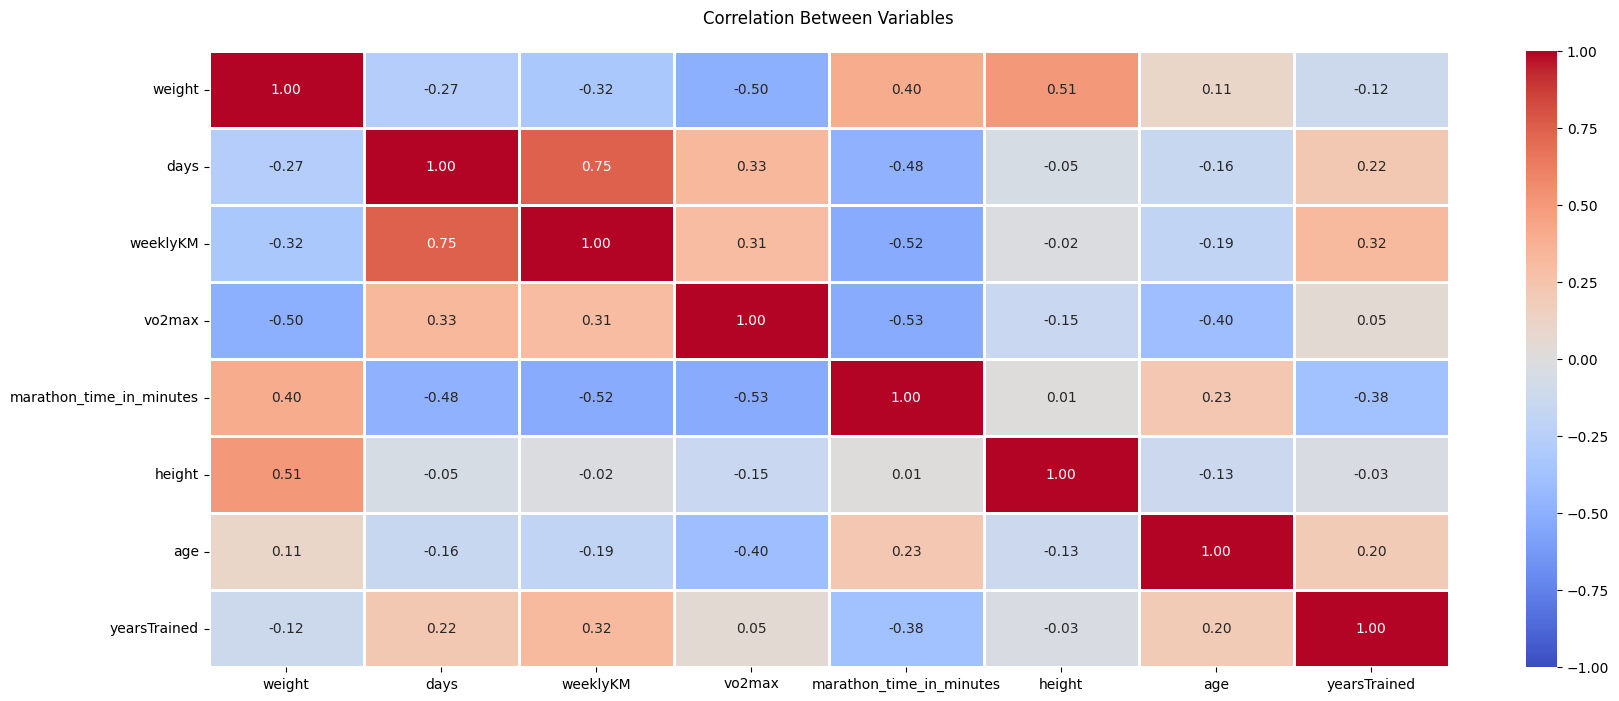

In [305]:
bb = data[['weight', 'days', 'weeklyKM', 'vo2max','marathon_time_in_minutes', 'height', 'age', 'yearsTrained' ]] 
corr = bb.corr()
plt.figure(figsize=(20, 8))  

sns.heatmap(corr, vmin=-1, vmax=1, cmap = 'coolwarm', annot=True, fmt='.2f', linewidths=1)
plt.title("Correlation Between Variables", pad=20)

REMEMBER !!!!  we investigate both negative and posiive influence

## __*TRAIN AND PERFORM MULTIOUPUT LINEAR REGRESSION*__ 

__scickit.lern implementation__

In [306]:
def perform_linear_regresson(x,y):

    X_train,X_test,y_train,y_test = train_test_split(x,y, test_size=0.2, random_state=42)
    ln = MultiOutputRegressor(LinearRegression())
    ln = ln.fit(X_train, y_train)
    pred = ln.predict(X_test)

    score = ln.score(X_train, y_train)
    mse = mean_squared_error(y_test,pred)
    r2 = r2_score(y_test,pred)
    coeff = [estimator.coef_ for estimator in ln.estimators_]


    return ln,mse,r2,y_test,pred,score,coeff

In [307]:
ln,mse,r2,y_test,pred,score,coeff = perform_linear_regresson(X_marathon,y_marathon)

print(f'mse is : {mse}')
print(f'r2 is : {r2}')
print(f'score is : {score}')

mse is : 157.49171103929837
r2 is : 0.23847490469291574
score is : 0.36257427636137335


## __OLS LINEAR REGRESSION INVESTIGATION__

### __PREDICT each multioutput realization separately and store them__

In [308]:
data_ols = data[['marathon_time_in_minutes', 'height', 'age', 'yearsTrained', 'weight', 'days', 'weeklyKM', 'vo2max']]

train, test = train_test_split(data_ols, test_size=0.4, random_state=42)

models = []
for i,col in enumerate(y_marathon):
    model = smf.ols(f"{col} ~ marathon_time_in_minutes + height + age + yearsTrained ", data=train).fit()
    models.append(model)

### __K-FOLD FUNCTION__

**K-FOLD:** 

- Splits datarandomly given shuffle=True, completely ignores the distribution, 
- May result inimblanced class proportions in each fold

**STRATIFIED K-FOLD:**

- Splits data into folds while preserving disributions 
- Each fold will have roughly the same proportion of each class
- *MAINLY USED FOR CLASSIFICTION PROBLEMS, CANNOT BE USED HERE WE HAVE NO LABELS* 
 

In [309]:
def compute_K_fold(X,y,splits):
    scores=[] 
    rmse_list=[]
    lrmodel = LinearRegression()
    cv = KFold(n_splits=splits, random_state=42, shuffle=True)
    for train_index, test_index in cv.split(X):
        X_train, X_test, y_train, y_test = X.iloc[train_index], X.iloc[test_index], y.iloc[train_index], y.iloc[test_index]
        lrmodel.fit(X_train, y_train)
        y_predict = lrmodel.predict(X_test)
        scores.append(lrmodel.score(X_test, y_test))
        rmse_fold = rmse(y_test, y_predict)
        rmse_list.append(rmse_fold)

    return scores,rmse_list

### __LEAVE ONE OUT FUNCTION__

In [310]:
def compute_loo_fold(X,y):
    rmse_list=[]
    lrmodel = LinearRegression()
    loo = LeaveOneOut()
    for train_index, test_index in loo.split(X):
        X_train, X_test, y_train, y_test = X.iloc[train_index], X.iloc[test_index], y.iloc[train_index], y.iloc[test_index]
        lrmodel.fit(X_train, y_train)
        y_predict = lrmodel.predict(X_test)
        rmse_fold = rmse(y_test, y_predict)
        rmse_list.append(rmse_fold)

    return rmse_list

### 
__INTRODUCTION FOR THE ANALYSIS__

The P-value is used to conclude if there is any relationship between the predictor and the realization :

-  A low value P < 0.05 means that coefficint beta associated to that varible is not equal to zero hence the varible is influencing the outcome
- A high P > 0.05 means that we caanot confidently say that this variable is affecting the outcome

The thresold 0.05 is associated to the rejection of the null hypothesis where we state that the null hypoesis is __Wrongly__ rejected 5% of the time 

If the P value is for example a high percentage, we coclude that with that percentage the coefficient couldbe 0, hence not influencing 

#### __INVESTIGATE Y REALIZATIONS SINGULARLY. (real Y as realization)__                                       

##### __WEIGHT -- as realization__

In [311]:
print(f'model summary for value {models[0].model.endog_names} \n \n {models[0].summary()}')

model summary for value weight 
 
                             OLS Regression Results                            
Dep. Variable:                 weight   R-squared:                       0.327
Model:                            OLS   Adj. R-squared:                  0.290
Method:                 Least Squares   F-statistic:                     8.981
Date:                Mon, 14 Apr 2025   Prob (F-statistic):           5.73e-06
Time:                        20:38:57   Log-Likelihood:                -266.46
No. Observations:                  79   AIC:                             542.9
Df Residuals:                      74   BIC:                             554.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------

In [312]:
p = models[0].predict(test)
print("Test weight R² (generalization):", r2_score(test["weight"], p))

Test weight R² (generalization): 0.4535424959857881


Height given the p value is strongly effecting the weight, this is expected because normally higher people tend to weight more given the fact that they have way more mass.

Age and Years Trained have a high percentage of having a 0 valued coefficient resulting in a null influence on weight.  

R2 on unseen data is very high which means we we are able to predict veery well weight!!!

##### __KFOLD WEIGHT CHECK__

In [313]:
X = data[['marathon_time_in_minutes', 'height', 'age', 'yearsTrained']]
y = data[['weight']]
r2_scores_ten,rmses_ten = compute_K_fold(X,y,10)
r2_scores_five,rmses_five = compute_K_fold(X,y,5)


print(f"R2 Squared Mean -> 10 folds: {np.mean(r2_scores_ten)} vs 5 folds: {np.mean(r2_scores_five)} ")
print(f"RMSE -> 10 folds: {np.mean(rmses_ten)} vs 5 folds: {np.mean(rmses_five)} ")

R2 Squared Mean -> 10 folds: 0.25587461877073825 vs 5 folds: 0.33521744968198025 
RMSE -> 10 folds: 7.2495124298340645 vs 5 folds: 7.356974831499551 


##### __LEAVE ONE OUT WEIGHT CHECK__

In [314]:
X = data[['marathon_time_in_minutes', 'height', 'age', 'yearsTrained']]
y = data[['weight']]
rmses= compute_loo_fold(X,y)

print(f"RMSE MEAN : {np.mean(rmses)}\n")
for i,r in enumerate(rmses):
    print(f"Fold nr {i+1} differed by {r}")

RMSE MEAN : 5.554276575618138

Fold nr 1 differed by [1.28046066]
Fold nr 2 differed by [0.07627103]
Fold nr 3 differed by [4.19815532]
Fold nr 4 differed by [6.974293]
Fold nr 5 differed by [7.16678853]
Fold nr 6 differed by [4.67092403]
Fold nr 7 differed by [3.41072405]
Fold nr 8 differed by [2.06688583]
Fold nr 9 differed by [5.17021091]
Fold nr 10 differed by [4.16020953]
Fold nr 11 differed by [7.414933]
Fold nr 12 differed by [3.72530711]
Fold nr 13 differed by [14.01490977]
Fold nr 14 differed by [2.97280248]
Fold nr 15 differed by [5.58323179]
Fold nr 16 differed by [0.44439366]
Fold nr 17 differed by [17.43110154]
Fold nr 18 differed by [7.55914185]
Fold nr 19 differed by [0.61773279]
Fold nr 20 differed by [9.8135516]
Fold nr 21 differed by [3.48335878]
Fold nr 22 differed by [1.37184699]
Fold nr 23 differed by [11.75778813]
Fold nr 24 differed by [5.51219594]
Fold nr 25 differed by [2.31758583]
Fold nr 26 differed by [2.29081557]
Fold nr 27 differed by [11.67565789]
Fold nr

##### __DAYS -- as realization__

In [315]:
print(f'model summary for value {models[1].model.endog_names} \n \n {models[1].summary()}')

model summary for value days 
 
                             OLS Regression Results                            
Dep. Variable:                   days   R-squared:                       0.213
Model:                            OLS   Adj. R-squared:                  0.171
Method:                 Least Squares   F-statistic:                     5.010
Date:                Mon, 14 Apr 2025   Prob (F-statistic):            0.00125
Time:                        20:38:58   Log-Likelihood:                -118.88
No. Observations:                  79   AIC:                             247.8
Df Residuals:                      74   BIC:                             259.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------

In [316]:
pp = models[1].predict(test)
print("Test days R² (generalization):", r2_score(test["marathon_time_in_minutes"], pp))

Test days R² (generalization): -33.95251631781331


Days looks very bad, in the sense that neither of the predictors seem to be able to predict the days of training. This is somehow expected given that sometimes most people train based on their daily needs, working time and tireness. Maybe someone has more time on certain days so runs more in a single day compared to spreading it in multiple days.

This needs o be taken into account.

R2 on unseen data is negative which is not good at all

##### __KFOLD DAYS CHECK__

In [317]:
X = data[['marathon_time_in_minutes', 'height', 'age', 'yearsTrained']]
y = data[['days']]
r2_scores_ten,rmses_ten = compute_K_fold(X,y,10)
r2_scores_five,rmses_five = compute_K_fold(X,y,5)


print(f"R2 Squared Mean -> 10 folds: {np.mean(r2_scores_ten)} vs 5 folds: {np.mean(r2_scores_five)} ")
print(f"RMSE -> 10 folds: {np.mean(rmses_ten)} vs 5 folds: {np.mean(rmses_five)} ")

R2 Squared Mean -> 10 folds: -0.004400492403097556 vs 5 folds: 0.004994129912372492 
RMSE -> 10 folds: 1.1327611888861169 vs 5 folds: 1.156113877985447 


##### __LEAVE ONE OUT DAYS CHECK__

In [318]:
X = data[['marathon_time_in_minutes', 'height', 'age', 'yearsTrained']]
y = data[['days']]
rmses= compute_loo_fold(X,y)

print(f"RMSE MEAN : {np.mean(rmses)}\n")
for i,r in enumerate(rmses):
    print(f"Fold nr {i+1} differed by {r}")

RMSE MEAN : 0.8611045756964749

Fold nr 1 differed by [0.93674162]
Fold nr 2 differed by [0.70492966]
Fold nr 3 differed by [0.41492485]
Fold nr 4 differed by [0.02840862]
Fold nr 5 differed by [0.50102901]
Fold nr 6 differed by [0.05662981]
Fold nr 7 differed by [1.27767272]
Fold nr 8 differed by [1.38613547]
Fold nr 9 differed by [0.24371773]
Fold nr 10 differed by [0.33729205]
Fold nr 11 differed by [0.08926233]
Fold nr 12 differed by [0.09444396]
Fold nr 13 differed by [0.8778908]
Fold nr 14 differed by [1.76825668]
Fold nr 15 differed by [1.52960119]
Fold nr 16 differed by [0.64370518]
Fold nr 17 differed by [1.64455699]
Fold nr 18 differed by [0.27686149]
Fold nr 19 differed by [2.48400744]
Fold nr 20 differed by [1.51953765]
Fold nr 21 differed by [0.34134154]
Fold nr 22 differed by [0.3087032]
Fold nr 23 differed by [0.79423721]
Fold nr 24 differed by [0.38766783]
Fold nr 25 differed by [1.96895533]
Fold nr 26 differed by [1.52726103]
Fold nr 27 differed by [0.82972617]
Fold nr

##### __WEEKLYKM -- as realization__

In [319]:
print(f'model summary for value {models[2].model.endog_names} \n \n {models[2].summary()}')

model summary for value weeklyKM 
 
                             OLS Regression Results                            
Dep. Variable:               weeklyKM   R-squared:                       0.364
Model:                            OLS   Adj. R-squared:                  0.330
Method:                 Least Squares   F-statistic:                     10.59
Date:                Mon, 14 Apr 2025   Prob (F-statistic):           7.73e-07
Time:                        20:38:59   Log-Likelihood:                -325.27
No. Observations:                  79   AIC:                             660.5
Df Residuals:                      74   BIC:                             672.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------

In [320]:
ppp = models[2].predict(test)
print("Test weeklyKM R² (generalization):", r2_score(test["marathon_time_in_minutes"], ppp))

Test weeklyKM R² (generalization): -21.07841400740253


##### __KFOLD WEEKLYKM CHECK__

In [321]:
X = data[['marathon_time_in_minutes', 'height', 'age', 'yearsTrained']]
y = data[['weeklyKM']]
r2_scores_ten,rmses_ten = compute_K_fold(X,y,10)
r2_scores_five,rmses_five = compute_K_fold(X,y,5)


print(f"R2 Squared Mean -> 10 folds: {np.mean(r2_scores_ten)} vs 5 folds: {np.mean(r2_scores_five)} ")
print(f"RMSE -> 10 folds: {np.mean(rmses_ten)} vs 5 folds: {np.mean(rmses_five)} ")

R2 Squared Mean -> 10 folds: -0.014715954135493347 vs 5 folds: 0.07328297328511309 
RMSE -> 10 folds: 18.156383254774102 vs 5 folds: 18.437469461619706 


In this case yearsTrained has a low P-value but not lower than 0.05 which means that we would have a higher chance of wrongly rejecting the null hypothesis, though compared to height and age, it seems resonable that someone that has been training for longer time then could run more km weekly

R2 on unseen data is negative which is not good at all.

##### __LEAVE ONE OUT WEEKLYKM CHECK__ 

In [322]:
X = data[['marathon_time_in_minutes', 'height', 'age', 'yearsTrained']]
y = data[['weeklyKM']]
rmses= compute_loo_fold(X,y)

print(f"RMSE MEAN : {np.mean(rmses)}\n")
for i,r in enumerate(rmses):
    print(f"Fold nr {i+1} differed by {r}")

RMSE MEAN : 13.661087303300423

Fold nr 1 differed by [12.80088783]
Fold nr 2 differed by [34.42689033]
Fold nr 3 differed by [10.59214057]
Fold nr 4 differed by [0.01765344]
Fold nr 5 differed by [47.98481293]
Fold nr 6 differed by [7.33838591]
Fold nr 7 differed by [5.83677414]
Fold nr 8 differed by [5.95797943]
Fold nr 9 differed by [4.75985927]
Fold nr 10 differed by [9.31505078]
Fold nr 11 differed by [4.24479226]
Fold nr 12 differed by [3.29807262]
Fold nr 13 differed by [12.87501861]
Fold nr 14 differed by [36.55211457]
Fold nr 15 differed by [11.67504708]
Fold nr 16 differed by [5.95618094]
Fold nr 17 differed by [12.25203127]
Fold nr 18 differed by [11.34028979]
Fold nr 19 differed by [38.0409507]
Fold nr 20 differed by [26.65048559]
Fold nr 21 differed by [6.22202014]
Fold nr 22 differed by [4.62602675]
Fold nr 23 differed by [27.65194478]
Fold nr 24 differed by [7.20010761]
Fold nr 25 differed by [30.19162736]
Fold nr 26 differed by [28.82963967]
Fold nr 27 differed by [17.2

##### __VO2MAX -- as realization__

In [323]:
print(f'model summary for value {models[3].model.endog_names} \n \n {models[3].summary()}')

model summary for value vo2max 
 
                             OLS Regression Results                            
Dep. Variable:                 vo2max   R-squared:                       0.456
Model:                            OLS   Adj. R-squared:                  0.426
Method:                 Least Squares   F-statistic:                     15.50
Date:                Mon, 14 Apr 2025   Prob (F-statistic):           2.98e-09
Time:                        20:38:59   Log-Likelihood:                -254.83
No. Observations:                  79   AIC:                             519.7
Df Residuals:                      74   BIC:                             531.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------

In [324]:
pppp = models[3].predict(test)
print("Test vo2max R² (generalization):", r2_score(test["marathon_time_in_minutes"], pppp))

Test vo2max R² (generalization): -22.29902502144954


As already discussed in EDA, as age increases, vo2max is lower and linear regression is fully able to get that and recognises that age has a very high impact on vo2max. Given this it makes sense to have age as a predictor in order to be able to influence the vo2max prediction. 

- Moreover is to investigate the effect that vo2max has on marathon time. 

R2 is negative on unseen data which means it is not very good!!

##### __K_FOLD VO2MAX CHECK__

In [325]:
X = data[['marathon_time_in_minutes', 'height', 'age', 'yearsTrained']]
y = data[['vo2max']]
r2_scores_ten,rmses_ten = compute_K_fold(X,y,10)
r2_scores_five,rmses_five = compute_K_fold(X,y,5)


print(f"R2 Squared Mean -> 10 folds: {np.mean(r2_scores_ten)} vs 5 folds: {np.mean(r2_scores_five)} ")
print(f"RMSE -> 10 folds: {np.mean(rmses_ten)} vs 5 folds: {np.mean(rmses_five)} ")

R2 Squared Mean -> 10 folds: 0.2806815002165103 vs 5 folds: 0.3101501781729944 
RMSE -> 10 folds: 6.263233224266466 vs 5 folds: 6.429429300923029 


##### __LEAVE ONE OUT VO2MAX CHECK__

In [326]:
X = data[['marathon_time_in_minutes', 'height', 'age', 'yearsTrained']]
y = data[['vo2max']]
rmses= compute_loo_fold(X,y)

print(f"RMSE MEAN : {np.mean(rmses)}\n")
for i,r in enumerate(rmses):
    print(f"Fold nr {i+1} differed by {r}")

RMSE MEAN : 5.3633343290094455

Fold nr 1 differed by [7.20792236]
Fold nr 2 differed by [10.83463803]
Fold nr 3 differed by [8.16290726]
Fold nr 4 differed by [7.66835325]
Fold nr 5 differed by [4.53032136]
Fold nr 6 differed by [1.0160889]
Fold nr 7 differed by [0.5473641]
Fold nr 8 differed by [11.95275596]
Fold nr 9 differed by [9.6256111]
Fold nr 10 differed by [5.07838802]
Fold nr 11 differed by [14.96579737]
Fold nr 12 differed by [10.02390122]
Fold nr 13 differed by [5.19458489]
Fold nr 14 differed by [2.51851885]
Fold nr 15 differed by [4.49372755]
Fold nr 16 differed by [4.98803984]
Fold nr 17 differed by [0.83706595]
Fold nr 18 differed by [1.07387612]
Fold nr 19 differed by [0.87967109]
Fold nr 20 differed by [7.36106909]
Fold nr 21 differed by [13.01388147]
Fold nr 22 differed by [5.03836574]
Fold nr 23 differed by [3.26357029]
Fold nr 24 differed by [5.38546799]
Fold nr 25 differed by [4.79666244]
Fold nr 26 differed by [4.99639293]
Fold nr 27 differed by [2.50568061]
Fol

##### __HISTOGRAMS__

In [347]:
def plot_histogram_single_features(usr_input,title,y_axis,x_axis):
    # Feature names and their corresponding "realization" values
    features = list(usr_input.keys())
    values = [] 
    for i,ft in enumerate(features):
        values.append(usr_input[ft])


    # Plotting
    plt.figure(figsize=(8, 5))
    bars = plt.bar(features, values, color='skyblue', edgecolor='black')

    # Add value labels on top of each bar
    for bar, importance in zip(bars, values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                 f'{importance:.2f}', ha='center', va='bottom', fontsize=10)

    plt.title(f'{title}', fontsize=14)
    plt.ylabel(y_axis)
    plt.xlabel(x_axis)

    mx = 0
    for val in values:
        if val > mx :
            mx = val

    plt.ylim(0, mx + 10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

In [362]:
# converts marathon times from minutes to hr.mm
def convert_marathon_time(time):
    rest = 0
    while(time % 60 != 0):
        rest += 1
        time -= 1
    return str(time//60) + str(rest)

# performs actual prediction and returns an object with the realizations values
def run_trial(user_input,regressor,realization):
    user_input_df = pd.DataFrame([user_input])
    predictions = regressor.predict(user_input_df)

    realizations_obj = {
        'time': convert_marathon_time(user_input["marathon_time_in_minutes"]),
    }
    realizations_obj[realization] = predictions[0] 
    
    return realizations_obj


def construct_user (time,height,age,yearsTrained) :
    user = {
        'marathon_time_in_minutes': time,
        'height' : height,
        'age' : age,
        'yearsTrained' : yearsTrained,
    }
    return user

# NOTE: users is a list of prdiction objects
def construct_single_feature_user(pred,y):
    realization = {}
    times = ['five', 'four_t', 'four', 'three_t', 'three', 'two_f']
    
    # NOTE: a prediction user is an object with weight,days,weeklyKM,vo2max
    for i,p in enumerate(pred):
        realization[times[i]]=p[y]

    return realization

# NOTE: returns a list of prediction objects
def make_trials(regressor,times, unchanged, realization):
    trials = []
    for i,time in enumerate(times):
        # NOTE: CALLING run_trial, hence returning prediction objects
        res = run_trial(construct_user(time, **unchanged), regressor,realization)
        trials.append(res)
    return trials

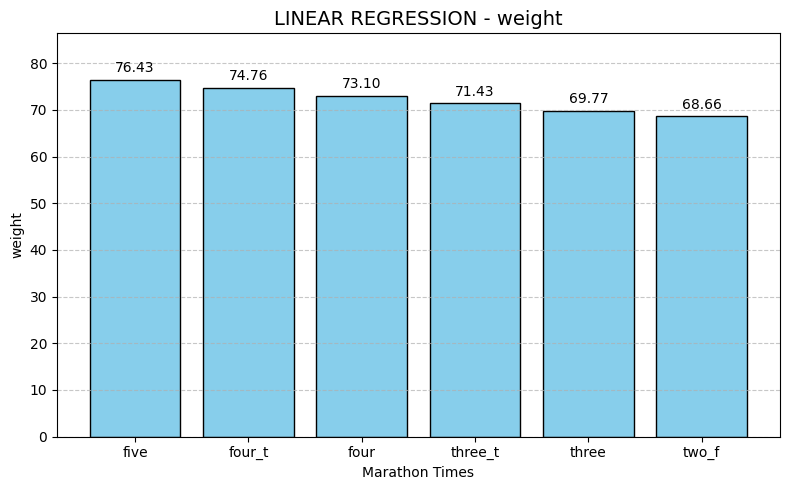

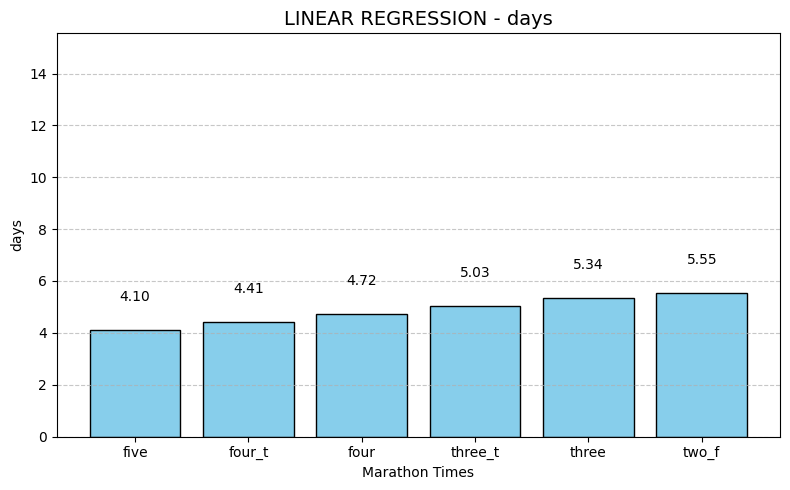

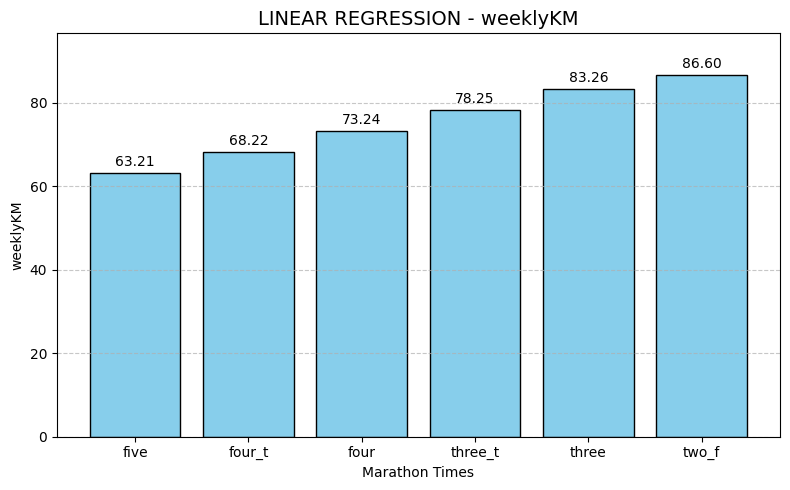

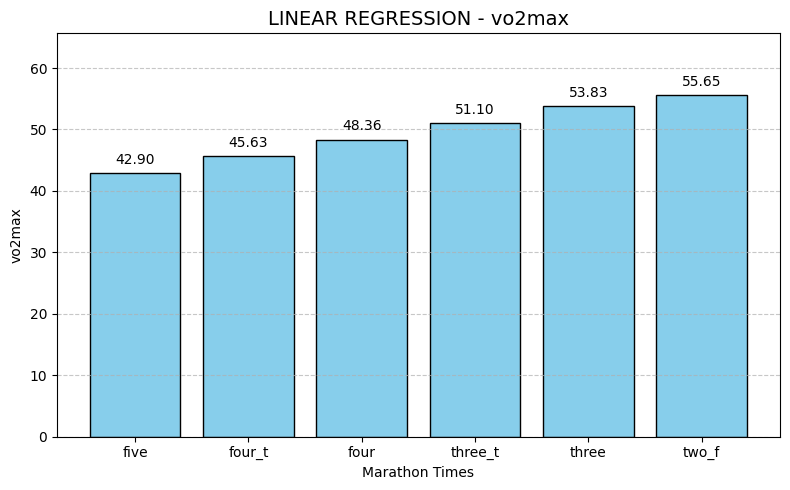

In [365]:
# NOTE!! this are unchanged because we need to test results for different times but same metrics to see if actually methods performs
unchanged = {
    'height' : 174,
    'age' : 36,
    'yearsTrained' : 24,
}
# prediction_arr = list(construct_single_feature_user(make_trials(models[0],[300,270,240,210,180,160],unchanged)))

# for i,pred_elem in enumerate(prediction_arr):
#     title = ['weight']
#     plot_histogram_single_features(pred_elem, f'EXTRA TREE - {title[i]}', title[i],'Marathon Times')

prediction_obj1 = construct_single_feature_user(
    make_trials(models[0], [300, 270, 240, 210, 180, 160], unchanged, 'weight'),
    'weight'
)
prediction_obj2 = construct_single_feature_user(
    make_trials(models[1], [300, 270, 240, 210, 180, 160], unchanged, 'days'), 
    'days'
)
prediction_obj3 = construct_single_feature_user(
    make_trials(models[2], [300, 270, 240, 210, 180, 160], unchanged, 'weeklyKM'), 
    'weeklyKM'
)
prediction_obj4 = construct_single_feature_user(
    make_trials(models[3], [300, 270, 240, 210, 180, 160], unchanged, 'vo2max'), 
    'vo2max'
)

# plot histogram for weight prediction across marathon times
plot_histogram_single_features(prediction_obj1, 'LINEAR REGRESSION - weight','weight','Marathon Times')
plot_histogram_single_features(prediction_obj2, 'LINEAR REGRESSION - days','days','Marathon Times')
plot_histogram_single_features(prediction_obj3, 'LINEAR REGRESSION - weeklyKM','weeklyKM','Marathon Times')
plot_histogram_single_features(prediction_obj4, 'LINEAR REGRESSION - vo2max','vo2max','Marathon Times')

#### __INVESTIGATE EFFECT OF Y REALIZATIONS AS PREDICOTORS FOR MARATHON TIME. (real Y as predictor)__ 

##### __All predictors against marathon_time__

In [327]:
model_all = smf.ols(f" marathon_time_in_minutes ~ weight + days + weeklyKM + vo2max ", data=train).fit()
print(model_all.summary())

                               OLS Regression Results                               
Dep. Variable:     marathon_time_in_minutes   R-squared:                       0.461
Model:                                  OLS   Adj. R-squared:                  0.432
Method:                       Least Squares   F-statistic:                     15.82
Date:                      Mon, 14 Apr 2025   Prob (F-statistic):           2.12e-09
Time:                              20:39:00   Log-Likelihood:                -392.36
No. Observations:                        79   AIC:                             794.7
Df Residuals:                            74   BIC:                             806.6
Df Model:                                 4                                         
Covariance Type:                  nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------

In [328]:
pred__all = model_all.predict(test)
print("Test all R² (generalization):", r2_score(test["marathon_time_in_minutes"], pred__all))

Test all R² (generalization): 0.2903214015262914


##### __using only weeklykm and vo2max__

In [329]:
model_two = smf.ols(f" marathon_time_in_minutes ~ weeklyKM + vo2max ", data=train).fit()
print(model_two.summary())

                               OLS Regression Results                               
Dep. Variable:     marathon_time_in_minutes   R-squared:                       0.458
Model:                                  OLS   Adj. R-squared:                  0.444
Method:                       Least Squares   F-statistic:                     32.09
Date:                      Mon, 14 Apr 2025   Prob (F-statistic):           7.88e-11
Time:                              20:39:00   Log-Likelihood:                -392.59
No. Observations:                        79   AIC:                             791.2
Df Residuals:                            76   BIC:                             798.3
Df Model:                                 2                                         
Covariance Type:                  nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------

In [330]:
pred_two = model_two.predict(test)
print("Test weekly and weight R² (generalization):", r2_score(test["marathon_time_in_minutes"], pred_two))

Test weekly and weight R² (generalization): 0.26329047637412717


##### __Weight against marathon time__

In [331]:
model_weight = smf.ols(f" marathon_time_in_minutes ~ weight ", data=train).fit()
print(model_weight.summary())

                               OLS Regression Results                               
Dep. Variable:     marathon_time_in_minutes   R-squared:                       0.132
Model:                                  OLS   Adj. R-squared:                  0.121
Method:                       Least Squares   F-statistic:                     11.75
Date:                      Mon, 14 Apr 2025   Prob (F-statistic):           0.000978
Time:                              20:39:00   Log-Likelihood:                -411.16
No. Observations:                        79   AIC:                             826.3
Df Residuals:                            77   BIC:                             831.1
Df Model:                                 1                                         
Covariance Type:                  nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------

In [332]:
pred_weight = model_weight.predict(test)
print("Test days R² (generalization):", r2_score(test["marathon_time_in_minutes"], pred_weight))

Test days R² (generalization): 0.1532695555042245


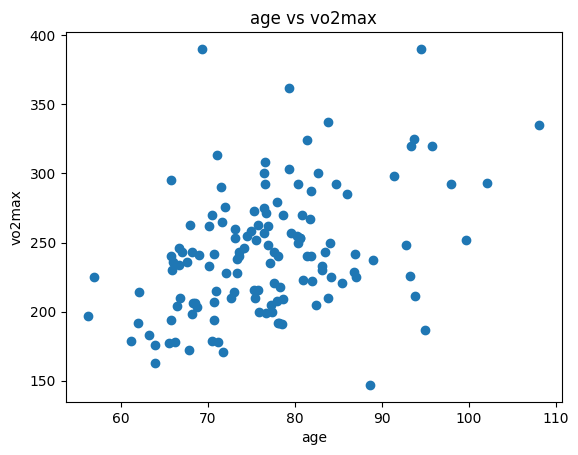

In [333]:
plt.scatter(data['weight'], data['marathon_time_in_minutes'])
plt.title('age vs vo2max')
plt.xlabel('age')
plt.ylabel('vo2max')
plt.show()

##### __days against marathon time__

In [334]:
model_days = smf.ols(f" marathon_time_in_minutes ~ days ", data=train).fit()
print(model_days.summary())

                               OLS Regression Results                               
Dep. Variable:     marathon_time_in_minutes   R-squared:                       0.199
Model:                                  OLS   Adj. R-squared:                  0.189
Method:                       Least Squares   F-statistic:                     19.13
Date:                      Mon, 14 Apr 2025   Prob (F-statistic):           3.78e-05
Time:                              20:39:00   Log-Likelihood:                -408.01
No. Observations:                        79   AIC:                             820.0
Df Residuals:                            77   BIC:                             824.8
Df Model:                                 1                                         
Covariance Type:                  nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------

In [335]:
pred_days = model_days.predict(test)
print("Test days R² (generalization):", r2_score(test["marathon_time_in_minutes"], pred_days))

Test days R² (generalization): 0.2566413364763567


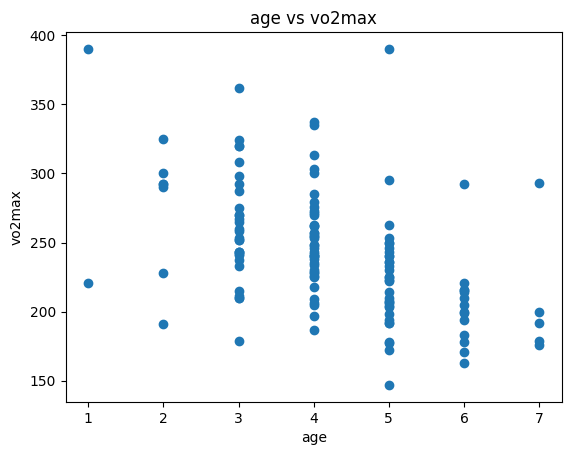

In [336]:
plt.scatter(data['days'], data['marathon_time_in_minutes'])
plt.title('age vs vo2max')
plt.xlabel('age')
plt.ylabel('vo2max')
plt.show()

##### __weeklyKM against marathon time__

In [337]:
model_weekly = smf.ols(f" marathon_time_in_minutes ~ weeklyKM ", data=data_ols).fit()
print(model_weekly.summary())

                               OLS Regression Results                               
Dep. Variable:     marathon_time_in_minutes   R-squared:                       0.275
Model:                                  OLS   Adj. R-squared:                  0.269
Method:                       Least Squares   F-statistic:                     49.21
Date:                      Mon, 14 Apr 2025   Prob (F-statistic):           1.14e-10
Time:                              20:39:00   Log-Likelihood:                -667.91
No. Observations:                       132   AIC:                             1340.
Df Residuals:                           130   BIC:                             1346.
Df Model:                                 1                                         
Covariance Type:                  nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------

In [338]:
pred_weekly= model_weekly.predict(test)
print("Test weeklyKM R² (generalization):", r2_score(test["marathon_time_in_minutes"], pred_weekly))

Test weeklyKM R² (generalization): 0.24783339643900315


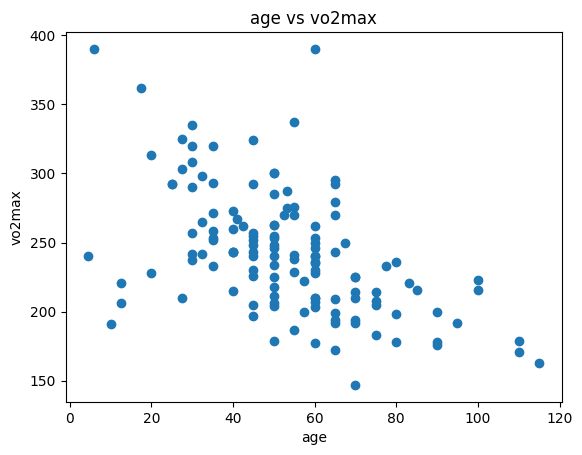

In [339]:
plt.scatter(data['weeklyKM'], data['marathon_time_in_minutes'])
plt.title('age vs vo2max')
plt.xlabel('age')
plt.ylabel('vo2max')
plt.show()

##### __vo2max against marathon time__

In [340]:
model_vo2max = smf.ols(f" marathon_time_in_minutes ~ vo2max ", data=train).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 vo2max   R-squared:                       0.456
Model:                            OLS   Adj. R-squared:                  0.426
Method:                 Least Squares   F-statistic:                     15.50
Date:                Mon, 14 Apr 2025   Prob (F-statistic):           2.98e-09
Time:                        20:39:00   Log-Likelihood:                -254.83
No. Observations:                  79   AIC:                             519.7
Df Residuals:                      74   BIC:                             531.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [341]:
pred_vo2max = model_vo2max.predict(test)
print("Test vo2max R² (generalization):", r2_score(test["marathon_time_in_minutes"], pred_vo2max))

Test vo2max R² (generalization): 0.2001214980153424


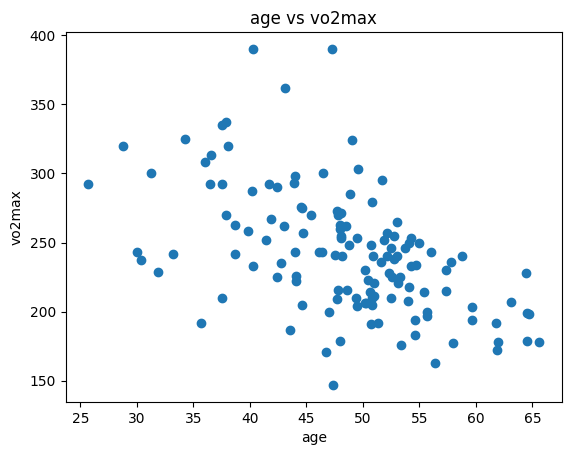

In [342]:
plt.scatter(data['vo2max'], data['marathon_time_in_minutes'])
plt.title('age vs vo2max')
plt.xlabel('age')
plt.ylabel('vo2max')
plt.show()

##### __DEMONSTRATION THAT NOT ALL P-VALUES ARE 0 -- bestSar (best sit and reach)__

In [343]:
data_with_sar = data[['marathon_time_in_minutes', 'height', 'age', 'yearsTrained', 'weight', 'days', 'weeklyKM', 'vo2max', 'bestSar']]

train_with_sar, test_wit_sar = train_test_split(data_with_sar, test_size=0.2, random_state=42)

model = smf.ols(f" marathon_time_in_minutes ~ bestSar ", data=train_with_sar).fit()
print(model.summary())

                               OLS Regression Results                               
Dep. Variable:     marathon_time_in_minutes   R-squared:                       0.001
Model:                                  OLS   Adj. R-squared:                 -0.008
Method:                       Least Squares   F-statistic:                    0.1383
Date:                      Mon, 14 Apr 2025   Prob (F-statistic):              0.711
Time:                              20:39:01   Log-Likelihood:                -549.52
No. Observations:                       105   AIC:                             1103.
Df Residuals:                           103   BIC:                             1108.
Df Model:                                 1                                         
Covariance Type:                  nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------

###

__ANALYSIS OUTCOME__

Single Predictors all have a P-value = 0.00 which means that they all strongly influence marathon time. 

Our model in facts aims at suggesting runners the best way to reach their desired marathon time, given weight, days, weeklyKM and vo2max as strong influencing predictors of marthon time, retrieving exactly this values from the multioutput tree analysis is the right way of solving the problem.

Every singular predictor is able to explain in between 25% - 30% of overall marathon time variance which for the amount of data that we have is not too bad. All p-values singularly have value = 0.00 which means strong influence.

When the predictors are combined together in predicting marathon time, the overall explained variance is around 40%- 45% which again not bad for the little amount of data that we have. P-values of weight and days are a bit high, around 0.2 which means that when combined with the others they are not as influencing as they are alone in predicting marathon time, still the singular prediction test (using only them singularly to predict the marathon time) tells us they they effectively influence the marathon time. Though evaluating a linear regression simply with weeklyKM and vo2max reaches the same variance explanation which mens we could lower the Y space to just weeklyKM and vo2max.

*TO CONCLUDE*

This analysis tells us that predicting the following parameters is effectively the right way of suggesting a runner the best metrics to improve on in order to reach his desired time. 

Though we need to take into account the fact that this variables (Y predictors) are the ones we are __predicting__ in multioutput trees, hence this metrics are just showing that we are predicting the right indicators for marthon time.

The analysis exemplifies also that when predicting this variables, given the low amount of data we have an r2 squared that is low.